In [1]:
import os
import sys
import matplotlib.pyplot as plt

path = os.getcwd()
if path.split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
from src.engine import Engine
from src.utils.util import load_log

/home/yo0n/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Load a model

In [3]:
config_path = 'configs/mln_resnet18_cub.yml'
save_dir = '/home/yo0n/바탕화면/RIL/ucam/notebook_test'
logger = load_log(save_dir)
checkpoint_path = '/home/yo0n/바탕화면/RIL/ucam/ckpt/checkpoint_best_ratio05_sig0105.pth'

In [4]:
engine = Engine(config_path, logger, save_dir,device='cuda')
engine.model_config['checkpoint_path'] = checkpoint_path
engine.define()


[2021-06-28 12:56:22,181 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] GPU is available.
[2021-06-28 12:56:25,453 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] SGD opimizer is built.
[2021-06-28 12:56:25,454 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] CUSTOM scheduler is built.
[2021-06-28 12:56:25,460 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Criterion is built.
[2021-06-28 12:56:25,460 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loss meter is built.
[2021-06-28 12:56:25,461 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Checkpointer is built.
[2021-06-28 12:56:25,461 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loading checkpoint from /home/yo0n/바탕화면/RIL/ucam/ckpt/checkpoint_best_ratio05_sig0105.pth
[2021-06-28 12:56:25,521 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Localizer is built.
[2021-06-28 12:56:25,521 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Evaluators are built.


In [5]:
vis_output = engine.visualization(mode='val', batch_indices=[i for i in range(10)])


/home/yo0n/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/yo0n/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/yo0n/.local/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instea

In [6]:
cams = vis_output['cams'].detach().cpu().numpy().transpose(0, 2, 3, 1)
blended_bboxes = vis_output['blended_bboxes'].detach().cpu().numpy().transpose(0, 2, 3, 1)


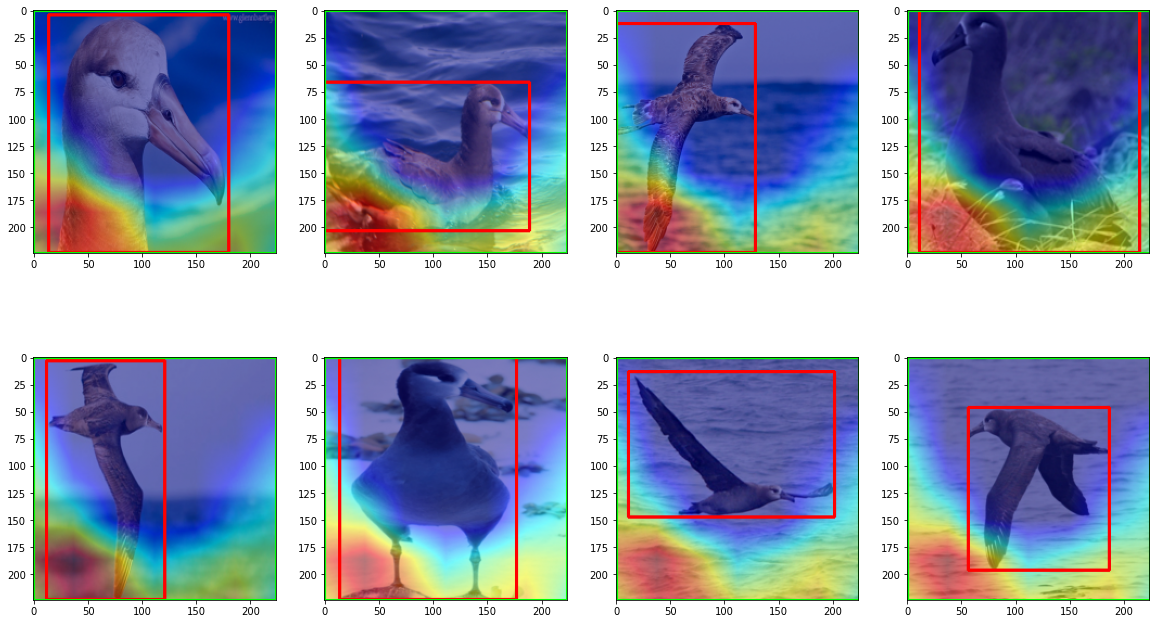

In [7]:
import random 

plot_num = 8
choice = random.sample([i for i in range(blended_bboxes.shape[0])], plot_num)
choice.sort()

choice = [i for i in range(plot_num)]

plt.figure(figsize=(20,50))
for idx,i in enumerate(choice):
    plt.subplot(plot_num,plot_num//2,idx+1)
    plt.imshow(blended_bboxes[i])
    

## Mask Out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


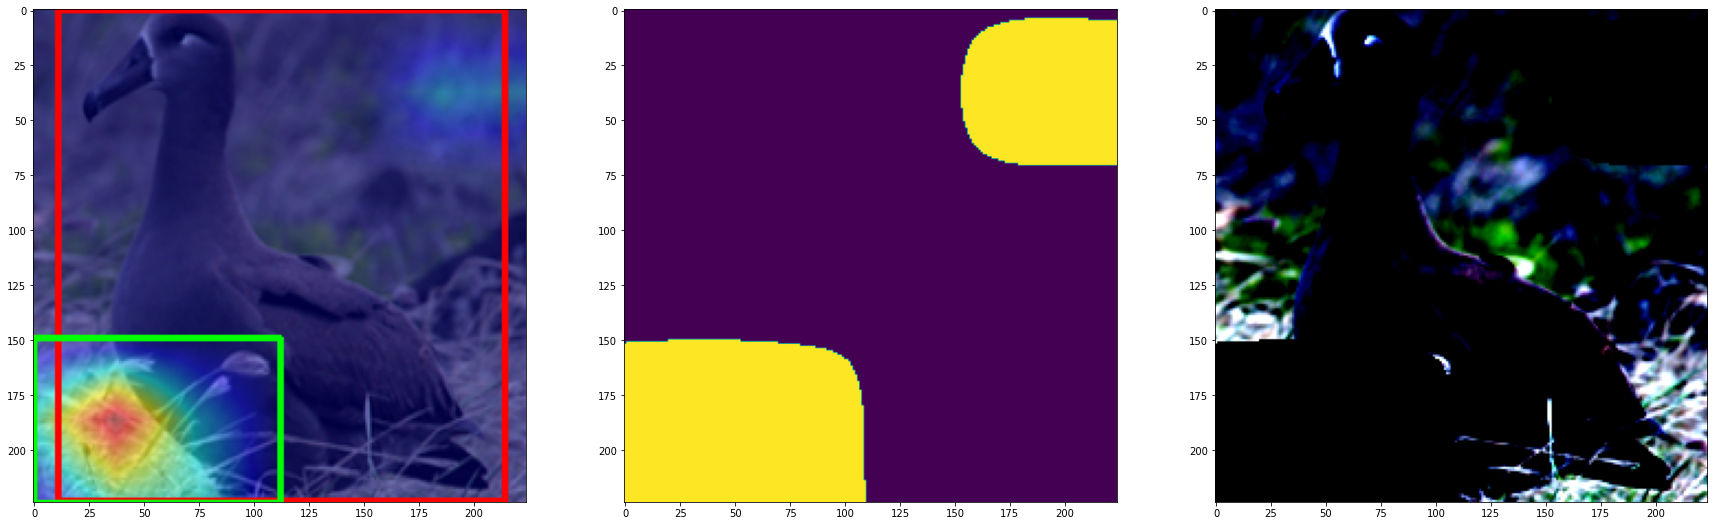

In [39]:
import numpy as np
index = 3
th = 1e-10

plt.figure(figsize=(30,60))
plt.subplot(3,3,1)
plt.imshow(blended_bboxes[index])

plt.subplot(3,3,2)
plt.imshow(cams[index] > th)

plt.subplot(3,3,3)
plt.imshow(images[index].permute(1,2,0).cpu().numpy()*(cams[index] <= th))

In [40]:
cams.shape

(5794, 224, 224, 1)

In [9]:
import numpy as np

loss_types = ['mace_avg','alea_avg','epis_avg']

confusion_matrix = np.zeros((21,3))
total_images = 0

for i, (images, labels, seglabel) in enumerate(engine.dataloaders['val']):
    total_images += images.size(0)
    
    for i,loss_type in enumerate(loss_types):
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type

        cams = engine.localizer.localize(images.to('cuda'), labels.to('cuda')) # [B X 1 X W X H]
        
        masks = cams > cams.mean(dim=[1,2,3]).view(-1,1,1,1) # [B X 1 X W X H]
        cams = cams.detach().cpu().numpy() # [B X 1 X W X H]
        masks = masks.detach().cpu().numpy()
        
        seglabel = np.where(seglabel==255, 0, seglabel)

        for b in range(images.size(0)):
            for c in range(21):
                union = np.bitwise_or(masks[b].squeeze(),seglabel[b].squeeze()==c)
                intersection = np.bitwise_and(masks[b].squeeze(),seglabel[b].squeeze()==c)
                
                if np.sum(union)==0:
                    confusion_matrix[c,i] += 0
                else:
                    confusion_matrix[c,i] += np.sum(intersection)/np.sum(union)

RuntimeError: The size of tensor a (128) must match the size of tensor b (200) at non-singleton dimension 1

In [53]:
alea_diff =list()
epis_diff = list()
for i in range(len(epis_mask)):
    alea_diff.append(alea_origin[i]-alea_mask[i])
    epis_diff.append(epis_origin[i]-epis_mask[i])

In [54]:
sum(alea_diff)/len(alea_diff),sum(epis_diff)/len(epis_diff)

(-0.6970083142071705, 0.0)

In [46]:
for i in range(len(epis_mask)):
    print(result_before['epis'][i], epis_mask[i])

0.010000008 0.010000008
0.010000632 0.010000632
0.010000411 0.010000411
0.010011145 0.010011145
0.010000048 0.010000048
0.010107902 0.010107902
0.010000008 0.010000008
0.010000356 0.010000356
0.010000037 0.010000037
0.010000515 0.010000515
0.010001754 0.010001754
0.010000003 0.010000003
0.011653759 0.011653759
0.010000212 0.010000212
0.014158544 0.014158544
0.010001687 0.010001687
0.010007993 0.010007993
0.010105579 0.010105579
0.010000752 0.010000752
0.010000259 0.010000259
0.010000776 0.010000776
0.010000093 0.010000093
0.010000025 0.010000025
0.01000468 0.01000468
0.010000165 0.010000165
0.010002904 0.010002904
0.010023145 0.010023145
0.010038659 0.010038659
0.010029866 0.010029866
0.010000138 0.010000138
0.010000038 0.010000038
0.010000007 0.010000007
0.010000079 0.010000079
0.010000005 0.010000005
0.010000121 0.010000121
0.01 0.01
0.010000001 0.010000001
0.010000046 0.010000046
0.010000397 0.010000397
0.010000185 0.010000185
0.0100000035 0.0100000035
0.0100000175 0.0100000175
0.01

0.014843318 0.014843318
0.010000017 0.010000017
0.01000005 0.01000005
0.01000006 0.01000006
0.010000895 0.010000895
0.010375513 0.010375513
0.010018015 0.010018015
0.010000489 0.010000489
0.010000001 0.010000001
0.010016788 0.010016788
0.010000044 0.010000044
0.013827478 0.013827478
0.010000608 0.010000608
0.0100000985 0.0100000985
0.010008743 0.010008743
0.010266504 0.010266504
0.013862536 0.013862536
0.010362973 0.010362973
0.010037066 0.010037066
0.010000632 0.010000632
0.010000009 0.010000009
0.010110056 0.010110056
0.010116006 0.010116006
0.011525592 0.011525592
0.010049172 0.010049172
0.010000001 0.010000001
0.010007254 0.010007254
0.013857507 0.013857507
0.010000004 0.010000004
0.010000702 0.010000702
0.01000001 0.01000001
0.010000008 0.010000008
0.01 0.01
0.010000013 0.010000013
0.01 0.01
0.0100000035 0.0100000035
0.01 0.01
0.010000006 0.010000006
0.01 0.01
0.010000001 0.010000001
0.010000083 0.010000083
0.01 0.01
0.010000341 0.010000341
0.01000045 0.01000045
0.010000001 0.0100

0.010142553 0.010142553
0.010000003 0.010000003
0.010002714 0.010002714
0.010005525 0.010005525
0.010000009 0.010000009
0.010000054 0.010000054
0.010005595 0.010005595
0.010021077 0.010021077
0.010028853 0.010028853
0.010000064 0.010000064
0.010029269 0.010029269
0.010000381 0.010000381
0.010000003 0.010000003
0.0108940415 0.0108940415
0.0100000715 0.0100000715
0.010104846 0.010104846
0.0100002615 0.0100002615
0.010000075 0.010000075
0.010025036 0.010025036
0.010148178 0.010148178
0.0100709945 0.0100709945
0.01002314 0.01002314
0.012600252 0.012600252
0.010000006 0.010000006
0.010646758 0.010646758
0.01000794 0.01000794
0.010000005 0.010000005
0.010000008 0.010000008
0.011261916 0.011261916
0.0100006135 0.0100006135
0.01000015 0.01000015
0.010191748 0.010191748
0.010000256 0.010000256
0.010000006 0.010000006
0.010000001 0.010000001
0.0100052385 0.0100052385
0.010452947 0.010452947
0.010007816 0.010007816
0.010000324 0.010000324
0.010001089 0.010001089
0.0102575375 0.0102575375
0.010001

0.010001153 0.010001153
0.010001449 0.010001449
0.010151232 0.010151232
0.010000938 0.010000938
0.010000863 0.010000863
0.010000683 0.010000683
0.010000416 0.010000416
0.010009976 0.010009976
0.010001488 0.010001488
0.0100025935 0.0100025935
0.010000395 0.010000395
0.010001903 0.010001903
0.010003573 0.010003573
0.010000955 0.010000955
0.010001149 0.010001149
0.010001979 0.010001979
0.010000887 0.010000887
0.010001909 0.010001909
0.010000189 0.010000189
0.010001128 0.010001128
0.010000972 0.010000972
0.011489052 0.011489052
0.010000849 0.010000849
0.010000465 0.010000465
0.010022978 0.010022978
0.010000527 0.010000527
0.010000933 0.010000933
0.012846406 0.012846406
0.010002769 0.010002769
0.010001548 0.010001548
0.010000699 0.010000699
0.010000949 0.010000949
0.011470738 0.011470738
0.0100131 0.0100131
0.010012878 0.010012878
0.010000237 0.010000237
0.010000774 0.010000774
0.01000875 0.01000875
0.01000063 0.01000063
0.010000796 0.010000796
0.01000267 0.01000267
0.010000315 0.010000315


0.010000382 0.010000382
0.010000999 0.010000999
0.010001608 0.010001608
0.010000203 0.010000203
0.010036657 0.010036657
0.010001022 0.010001022
0.010009236 0.010009236
0.0100194905 0.0100194905
0.010001454 0.010001454
0.010000365 0.010000365
0.010000592 0.010000592
0.010000007 0.010000007
0.010000243 0.010000243
0.0100005 0.0100005
0.010000504 0.010000504
0.010000507 0.010000507
0.010000467 0.010000467
0.010000159 0.010000159
0.010000715 0.010000715
0.010000978 0.010000978
0.010000805 0.010000805
0.010000928 0.010000928
0.010000574 0.010000574
0.010000603 0.010000603
0.010001991 0.010001991
0.010000978 0.010000978
0.010005888 0.010005888
0.010000222 0.010000222
0.010000749 0.010000749
0.010000604 0.010000604
0.010007383 0.010007383
0.010000392 0.010000392
0.010000025 0.010000025
0.0100077 0.0100077
0.010002344 0.010002344
0.01000055 0.01000055
0.010000245 0.010000245
0.010004202 0.010004202
0.010000465 0.010000465
0.010002372 0.010002372
0.010000444 0.010000444
0.010001367 0.010001367


0.01083707 0.01083707
0.010005168 0.010005168
0.010006294 0.010006294
0.01000409 0.01000409
0.010002509 0.010002509
0.010002414 0.010002414
0.010001906 0.010001906
0.010001166 0.010001166
0.01000129 0.01000129
0.010000529 0.010000529
0.0100005325 0.0100005325
0.010001081 0.010001081
0.010001214 0.010001214
0.010001768 0.010001768
0.010002005 0.010002005
0.010000176 0.010000176
0.010000571 0.010000571
0.010004877 0.010004877
0.010001423 0.010001423
0.010003605 0.010003605
0.010003166 0.010003166
0.010000986 0.010000986
0.010000803 0.010000803
0.0100008035 0.0100008035
0.010004616 0.010004616
0.010000598 0.010000598
0.010001073 0.010001073
0.01000121 0.01000121
0.010001933 0.010001933
0.010013258 0.010013258
0.0100008 0.0100008
0.010008269 0.010008269
0.010001909 0.010001909
0.010005148 0.010005148
0.010006964 0.010006964
0.010009707 0.010009707
0.010004205 0.010004205
0.010000614 0.010000614
0.0100010885 0.0100010885
0.0100060515 0.0100060515
0.011108109 0.011108109
0.010008211 0.010008

0.010001335 0.010001335
0.010000288 0.010000288
0.010001301 0.010001301
0.010000388 0.010000388
0.010002362 0.010002362
0.010000321 0.010000321
0.010000642 0.010000642
0.01000096 0.01000096
0.010000459 0.010000459
0.010000566 0.010000566
0.010002073 0.010002073
0.010000914 0.010000914
0.010001046 0.010001046
0.010000859 0.010000859
0.010000893 0.010000893
0.010000772 0.010000772
0.010003103 0.010003103
0.010000913 0.010000913
0.0100012785 0.0100012785
0.010003059 0.010003059
0.0100003565 0.0100003565
0.010000979 0.010000979
0.010001439 0.010001439
0.01000189 0.01000189
0.010000546 0.010000546
0.010000606 0.010000606
0.010001387 0.010001387
0.010002758 0.010002758
0.010002482 0.010002482
0.010002083 0.010002083
0.010001034 0.010001034
0.010001694 0.010001694
0.010001337 0.010001337
0.010001717 0.010001717
0.010000852 0.010000852
0.010001476 0.010001476
0.010001685 0.010001685
0.010001705 0.010001705
0.010002124 0.010002124
0.010002798 0.010002798
0.010002463 0.010002463
0.010001585 0.01

0.010001328 0.010001328
0.010003332 0.010003332
0.010002316 0.010002316
0.0100010885 0.0100010885
0.010002023 0.010002023
0.010904376 0.010904376
0.010048878 0.010048878
0.01000561 0.01000561
0.010049834 0.010049834
0.010560328 0.010560328
0.010019698 0.010019698
0.010000672 0.010000672
0.010008799 0.010008799
0.010000344 0.010000344
0.010000479 0.010000479
0.010120375 0.010120375
0.010001286 0.010001286
0.010014758 0.010014758
0.010005488 0.010005488
0.010001207 0.010001207
0.010003064 0.010003064
0.010269026 0.010269026
0.010015066 0.010015066
0.01001939 0.01001939
0.010006728 0.010006728
0.010013106 0.010013106
0.010007974 0.010007974
0.010634437 0.010634437
0.0100264605 0.0100264605
0.010115777 0.010115777
0.012060952 0.012060952
0.010006573 0.010006573
0.010188366 0.010188366
0.01000886 0.01000886
0.010001415 0.010001415
0.010005091 0.010005091
0.010000476 0.010000476
0.010005536 0.010005536
0.01001222 0.01001222
0.010000401 0.010000401
0.010001396 0.010001396
0.0100005185 0.01000

0.010000006 0.010000006
0.010031837 0.010031837
0.010000002 0.010000002
0.01000169 0.01000169
0.010000659 0.010000659
0.0100000035 0.0100000035
0.01 0.01
0.010000735 0.010000735
0.010000255 0.010000255
0.010000474 0.010000474
0.010000028 0.010000028
0.010028572 0.010028572
0.010011875 0.010011875
0.010001487 0.010001487
0.01000089 0.01000089
0.010004081 0.010004081
0.010078355 0.010078355
0.010000169 0.010000169
0.010000005 0.010000005
0.010000001 0.010000001
0.010027695 0.010027695
0.010000008 0.010000008
0.0100257 0.0100257
0.010000078 0.010000078
0.010000014 0.010000014
0.011960045 0.011960045
0.010051742 0.010051742
0.010002082 0.010002082
0.010030779 0.010030779
0.010011814 0.010011814
0.012041483 0.012041483
0.010004952 0.010004952
0.01000001 0.01000001
0.01000003 0.01000003
0.010122812 0.010122812
0.01 0.01
0.01 0.01
0.01 0.01
0.010000002 0.010000002
0.0102787865 0.0102787865
0.013229685 0.013229685
0.01 0.01
0.010000018 0.010000018
0.010000003 0.010000003
0.010165999 0.01016599